Using downloaded and verified file: binarized_mnist/binarized_mnist_train.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_valid.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_test.amat


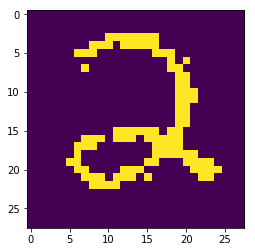

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 16 09:52:14 2019

@author: karm2204
"""



#####         https://chrisorm.github.io/VAE-pyt.html
#             Variational Autoencoder in Pytorch
#             https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
#             https://github.com/bobchennan/VAE_NBP/blob/master/vae_dp.py
#             https://github.com/pytorch/examples/blob/master/vae/main.py

from __future__ import print_function
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.autograd import Variable
from sklearn.mixture import BayesianGaussianMixture
import torch.optim as optim
import torch.utils.data
import argparse
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Hyper-parameters
batch_size = 128
learning_rate = 31e-4
image_size = 784
h_dim = 400
z_dim = 100
num_epochs = 20


#%%

def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

train_loader, valid_loader, test_loader = get_data_loader("binarized_mnist", batch_size)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train_loader:
    plt.imshow(x[0, 0])
    break
    


In [0]:
next(enumerate(train_loader))[1].size()

torch.Size([128, 1, 28, 28])

In [0]:
#%%
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=100):
        super(VAE, self).__init__()
        
#         self.encoder = nn.Sequential(nn.Linear(image_size, h_dim),\
#                                 nn.ReLU()\
#                                )
        self.encoder= nn.Sequential(nn.Conv2d(1,32,3),\
                                    nn.ELU(),\
                                    nn.AvgPool2d(2,2),\
                                    nn.Conv2d(32,64,3),\
                                    nn.ELU(),\
                                    nn.AvgPool2d(2,2),\
                                    nn.Conv2d(64,256,5),\
                                    nn.ELU(),\
                                    )
#         self.fc_1 = nn.Linear(image_size, h_dim)
        self.fc_1 = nn.Linear(256, z_dim)
        self.fc_2 = nn.Linear(256, z_dim)

        self.fc_3 = nn.Linear(z_dim, 256)
#         self.fc_5 = nn.Linear(h_dim, image_size)
        self.decoder= nn.Sequential(nn.ELU(),\
                                    nn.Conv2d(256,64,5, padding = 4),\
                                    nn.ELU(),\
                                    nn.UpsamplingBilinear2d(scale_factor=2),\
                                    nn.Conv2d(64, 32, 3, padding=2),\
                                    nn.ELU(),\
                                    nn.UpsamplingBilinear2d(scale_factor=2),\
                                    nn.Conv2d(32, 16, 3, padding=2),\
                                    nn.ELU(),\
                                    nn.Conv2d(16, 1, 3, padding=2),\
                                    nn.Sigmoid()
                                    )
        
    """ Encode a batch of samples, and return posterior parameters for each point."""    
    def encode(self, x):
#         h_1 = F.relu(self.fc_1(x))
      h_1 = self.encoder(x)
      return self.fc_1(h_1.view(-1,256)), self.fc_2(h_1.view(-1,256))


    """ Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation.
        For each training sample (we get 128 batched at a time)
        - take the current learned mu, stddev for each of the z_dim 
        (in the pytorch VAE example, this is 20, z_dim = 20)
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians
        Parameters
        ----------
        mu : [128, z_dim] mean matrix
        logvar : [128, z_dim] variance matrix
        Returns
        -------
        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.
        """
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std


    """ Decode a batch of latent variables"""
    def decode(self, z):
    #        h_3 = F.relu(self.fc_4(z))
    #        return F.sigmoid(self.fc_5(h_3))
        h_2 = self.fc_3(z).view(-1,256,1,1)
        h_3 = self.decoder(h_2)
        return h_3


    """ Takes a batch of samples, encodes them, and then decodes them again to compare."""
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [0]:
#%%
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
""" ELBO assuming entries of x are binary variables, with closed form KLD."""
def loss_function(x_reconst, x, mu, logvar):
    bce = F.binary_cross_entropy(x_reconst, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    # KLD /= x.view(-1, image_size).data.shape[0] * image_size
    return bce + KLD
#%%

# ----------
#  Train
# ----------
def train(epoch):
    model.train()
    train_loss = 0
    log_interval = 100
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 100. *
                batch_idx / len(train_loader), loss.item() / len(data)
            ))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

#%%

# ----------
#  Test
# ----------
def test(epoch):
    model.eval()
    test_loss = 0
    # ind = np.arange(x.shape[0])
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            data = data.to(device)
#           test_data = torch.from_numpy(test_data[np.random.choice(ind, size=batch_size)])
#           test_data = Variable(test_data, requires_grad=False)
            reconst_batch, mu, logvar = model(data)
            test_loss += loss_function(reconst_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 28)
                comparison = torch.cat([data[:n],
                                        reconst_batch.view(128, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)
#            print(data.view(batch_size, 2,2)[:n])
#            print(reconst_batch.view(batch_size, 2,2)[:n])
            
            
    test_loss /= len(valid_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
        
#%%    
if __name__ == "__main__":
    for epoch in range(1, 21):
        train(epoch)
        test(epoch)
        # 64 sets of random z_dim-float vectors, i.e. 64 locations / MNIST
        # digits in latent space
        with torch.no_grad():
            sample = torch.randn(128, z_dim).to(device)
            sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')
    torch.save(model.state_dict(), 'vae.pth')            
            
            

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [0/50000 (0%)]	 Loss: 542.836914
Train Epoch: 1 [12800/50000 (26%)]	 Loss: 194.689056
Train Epoch: 1 [25600/50000 (51%)]	 Loss: 153.315765
Train Epoch: 1 [38400/50000 (77%)]	 Loss: 138.516022


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([80, 784])) that is different to the input size (torch.Size([80, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> Epoch: 1 Average loss: 172.1882


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


====> Test set loss: 124.1842
Train Epoch: 2 [0/50000 (0%)]	 Loss: 127.390892
Train Epoch: 2 [12800/50000 (26%)]	 Loss: 118.126480
Train Epoch: 2 [25600/50000 (51%)]	 Loss: 115.278275
Train Epoch: 2 [38400/50000 (77%)]	 Loss: 115.700066
====> Epoch: 2 Average loss: 115.4474
====> Test set loss: 110.0458
Train Epoch: 3 [0/50000 (0%)]	 Loss: 110.079872
Train Epoch: 3 [12800/50000 (26%)]	 Loss: 105.505157
Train Epoch: 3 [25600/50000 (51%)]	 Loss: 108.556976
Train Epoch: 3 [38400/50000 (77%)]	 Loss: 102.728851
====> Epoch: 3 Average loss: 106.6912
====> Test set loss: 106.5019
Train Epoch: 4 [0/50000 (0%)]	 Loss: 106.464096
Train Epoch: 4 [12800/50000 (26%)]	 Loss: 107.817703
Train Epoch: 4 [25600/50000 (51%)]	 Loss: 101.382286
Train Epoch: 4 [38400/50000 (77%)]	 Loss: 101.188065
====> Epoch: 4 Average loss: 103.3573
====> Test set loss: 103.0445
Train Epoch: 5 [0/50000 (0%)]	 Loss: 102.834038
Train Epoch: 5 [12800/50000 (26%)]	 Loss: 99.405121
Train Epoch: 5 [25600/50000 (51%)]	 Loss: 101

In [0]:
#let's do it with a single batch of 128, we can adjust later
mean_val =  [None]*1000
sigma_val = [None]*1000
others = [None]*1000

for i, data in enumerate(test_loader):
  data = data.to(device)
  others[i], mean_val[i], sigma_val[i] = model(data)
#z_mean, z_log_var = model.encode()

mean_val_test = mean_val[0]
log_sigma_val_test = sigma_val[0]
images = others[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [0]:
sigma_val_test = torch.exp(log_sigma_val_test)

In [0]:
standard = torch.distributions.normal.Normal(torch.zeros(128,100).cuda(), torch.ones(128,100).cuda())
displaced = torch.distributions.normal.Normal(mean_val_test, log_sigma_val_test)

sample = displaced.sample(sample_shape=torch.Size())
samples = [displaced.sample(sample_shape=torch.Size()) for i in range(200)]

#p and q are (200, 128,100)
p_samples = torch.stack([torch.exp(standard.log_prob(samples[i])) for i in range(len(samples))])
q_samples = torch.stack([torch.exp(displaced.log_prob(samples[i])) for i in range(len(samples))])

#torch.Size([200, 128, 784])
reconstructions = torch.stack([model.decode(p_samples[i]).view(-1,784) for i in range(200)])


#decode a minibatch of samples for all K
second = images.view(-1,784)
loss_fc = torch.nn.BCELoss(reduction = 'sum')

((second * torch.log(reconstructions[0])) + ((1-second)*torch.log(1-reconstructions[0]))).size()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


torch.Size([128, 784])

In [0]:
# first = model.decode(p_samples[0]).view(-1,784)
# second = model.decode(p_samples[1]).view(-1,784)
# torch.stack([first,second]).size()
torch.log(reconstructions).size()
torch.cuda.empty_cache()